In [250]:
import os
import librosa
import librosa.display
import IPython.display as ipd
from IPython.display import display
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.gridspec import GridSpec
import math
from seaborn import heatmap
import seaborn as sns
from matplotlib import transforms
from skimage import metrics
import statistics
import copy
from scipy import optimize

In [251]:
def importAudio(target, reference, output=True):
    if(output):
        display(ipd.Audio(target))
        display(ipd.Audio(reference))

    tArray, tSampleRate = librosa.load(target)
    rArray, rSampleRate = librosa.load(reference)

    tSTFT = librosa.stft(tArray, n_fft=frameSize, hop_length=hopSize)
    rSTFT = librosa.stft(rArray, n_fft=frameSize, hop_length=hopSize)

    tDFT = librosa.stft(tArray, n_fft=frameSize, hop_length=10000000000)
    rDFT = librosa.stft(rArray, n_fft=frameSize, hop_length=10000000000)
    
    return ({"STFT":tSTFT,"DFT":tDFT,"sampleRate":tSampleRate},{"STFT":rSTFT,"DFT":rDFT,"sampleRate":rSampleRate})

In [252]:
def exportAudio(tAudio, mAudio, rAudio):
    print("Target")
    tInverse = librosa.istft(tAudio["STFT"],n_fft=frameSize, hop_length=hopSize)
    display(ipd.Audio(tInverse, rate=tAudio["sampleRate"]))

    print("Matched")
    mInverse = librosa.istft(mAudio["STFT"],n_fft=frameSize, hop_length=hopSize)
    display(ipd.Audio(mInverse, rate=mAudio["sampleRate"]))

    print("Reference")
    rInverse = librosa.istft(rAudio["STFT"],n_fft=frameSize, hop_length=hopSize)
    display(ipd.Audio(rInverse, rate=rAudio["sampleRate"]))

In [253]:
def plotSpectrogram(tAudio, mAudio, rAudio):

    maximum = (max(np.max(np.abs(tAudio["STFT"])**2), np.max(np.abs(rAudio["STFT"])**2)))
    
    # derives the spectrogram from the STFT
    tSpectrogram = librosa.power_to_db(np.abs(tAudio["STFT"])**2, ref=np.max)
    mSpectrogram = librosa.power_to_db(np.abs(mAudio["STFT"])**2, ref=np.max)
    rSpectrogram = librosa.power_to_db(np.abs(rAudio["STFT"])**2, ref=np.max)

    # creates plots of spectrograms
    fig, ax = plt.subplots(nrows=3, ncols=1, sharex=True, figsize=(10*figScale, 5*figScale))
    tImg = librosa.display.specshow(tSpectrogram,sr=tAudio["sampleRate"],hop_length=hopSize,x_axis="time",y_axis="mel",cmap="magma",ax=ax[0])
    mImg = librosa.display.specshow(mSpectrogram,sr=mAudio["sampleRate"],hop_length=hopSize,x_axis="time",y_axis="mel",cmap="magma",ax=ax[1])
    rImg = librosa.display.specshow(rSpectrogram,sr=rAudio["sampleRate"],hop_length=hopSize,x_axis="time",y_axis="mel",cmap="magma",ax=ax[2])

    # adjusts appearance
    ax[0].set(title='Target')
    ax[1].set(title='Matched')
    ax[2].set(title='Reference')
    for ax_i in ax:
        ax_i.label_outer()
    fig.colorbar(mImg, ax=[ax[0], ax[1], ax[2]],format='%+2.0f dB')


<h3>Matching based on gain average of frequency bands</h3>

In [254]:
def plotCurve(tCurve,tCurveSmooth,rCurve,rCurveSmooth,mCurve):
    plt.figure(figsize=(10*figScale,5*figScale))

    plt.plot(20*np.log10(tCurve), alpha=0.2, color='blue', label="Target")
    plt.plot(20*np.log10(tCurveSmooth), color='blue', label="Convolved Target")

    plt.plot(20*np.log10(rCurve), alpha=0.2, color='red', label="Reference")
    plt.plot(20*np.log10(rCurveSmooth), color='red', label="Convolved Reference")

    plt.plot(20*np.log10(mCurve), color='green', label="Matched")
    
    plt.xlabel("Frequency Bin")
    plt.ylabel("Gain (dB)")
    plt.legend()

In [255]:
def convolve(curve, smoothing):
    curve = np.ravel(curve)
    kernel = np.ones(smoothing) / smoothing
    curve = np.convolve(curve, kernel, mode='same')
    curve = curve.reshape(len(curve),1)
    return curve

def EQMatching(tAudio, rAudio, smoothing=1, plot=True):
    tCurve = np.abs(tAudio["DFT"])
    tCurveSmooth = convolve(tCurve, smoothing)

    rCurve = np.abs(rAudio["DFT"])
    rCurveSmooth = convolve(rCurve, smoothing)

    scaler = rCurveSmooth / tCurveSmooth
    
    mSTFT = tAudio["STFT"] * scaler
    mDFT = tAudio["DFT"] * scaler
    mAudio = {"STFT":mSTFT,"DFT":mDFT,"sampleRate":tAudio["sampleRate"]}

    if(plot):
        mCurve = np.abs(mDFT)
        plotCurve(tCurve,tCurveSmooth,rCurve,rCurveSmooth,mCurve)
    
    return mAudio

In [256]:
def plotDynamics(tSlice,rSlice,coeff,dynamicBins):

    #Grid
    fig = plt.figure(figsize=(14*figScale, 4*figScale))
    gs = GridSpec(6, 21, figure=fig)

    tLevel = fig.add_subplot(gs[0:3, 0:10])
    rLevel = fig.add_subplot(gs[3:6, 0:10])

    tResponse = fig.add_subplot(gs[0:5, 10:11])
    rResponse = fig.add_subplot(gs[0:5, 11:12])
    mResponse = fig.add_subplot(gs[0:5, 12:13])
    mrResponse = fig.add_subplot(gs[0:5, 13:14])
    preDist = fig.add_subplot(gs[5:6, 10:12])
    postDist = fig.add_subplot(gs[5:6, 12:14])

    mod = fig.add_subplot(gs[0:6, 15:21])
    fig.tight_layout(pad=1.0)
    plt.subplots_adjust(wspace=0.8)

    #abs
    tSlice = np.abs(tSlice)
    mSlice = np.abs(warp(tSlice,coeff))
    rSlice = np.abs(rSlice)



    #Level
    tLevel.plot(np.abs(tSlice),label="Unmatched",color='blue')
    tLevel.plot(np.abs(mSlice),label="Matched",color='red')
    rLevel.plot(np.abs(rSlice),color='green')

    tLevel.set_title('Target')
    tLevel.set_ylabel("Level")
    tLevel.legend()
    rLevel.set_title('Reference')
    rLevel.set_xlabel("Frame")
    rLevel.set_ylabel("Level")
    


    #Response
    tDynamicResponse, rDynamicResponse = getDynamicResponse(tSlice, rSlice, dynamicBins)
    reshape = np.flip(tDynamicResponse.reshape(tDynamicResponse.shape[0], 1))
    heat = heatmap(reshape, ax=tResponse, cmap="magma")
    for _, spine in heat.spines.items():
        spine.set_visible(True)
        spine.set_linewidth(1)
    reshape = np.flip(rDynamicResponse.reshape(rDynamicResponse.shape[0], 1))
    heat = heatmap(reshape, ax=rResponse, cmap="magma")
    for _, spine in heat.spines.items():
        spine.set_visible(True)
        spine.set_linewidth(1)
    tResponse.set_xticks([])
    tResponse.set_yticks([])
    rResponse.set_xticks([])
    rResponse.set_yticks([])
    tResponse.set_title('unmatched', fontsize=10)
    rResponse.set_title('ref', fontsize=10)

    mDynamicResponse, mrDynamicResponse = getDynamicResponse(mSlice, rSlice, dynamicBins)
    reshape = np.flip(mDynamicResponse.reshape(tDynamicResponse.shape[0], 1))
    heat = heatmap(reshape, ax=mResponse, cmap="magma")
    for _, spine in heat.spines.items():
        spine.set_visible(True)
        spine.set_linewidth(1)
    reshape = np.flip(mrDynamicResponse.reshape(rDynamicResponse.shape[0], 1))
    heat = heatmap(reshape, ax=mrResponse, cmap="magma")
    for _, spine in heat.spines.items():
        spine.set_visible(True)
        spine.set_linewidth(1)
    mResponse.set_xticks([])
    mResponse.set_yticks([])
    mrResponse.set_xticks([])
    mrResponse.set_yticks([])
    mResponse.set_title('matched', fontsize=10)
    mrResponse.set_title('ref', fontsize=10)

    preDist.set_title('Distance:')
    postDist.set_title('Distance:')
    preDist.axis("off")
    postDist.axis("off")
    preDist.text(0.5, 0.5, round(objective([1],tSlice,rSlice,dynamicBins),2), va="center", ha="center")
    postDist.text(0.5, 0.5, round(objective(coeff,tSlice,rSlice,dynamicBins),2), va="center", ha="center")



    #Modifier
    tMax = max(np.abs(tSlice))
    x = np.linspace(0,tMax,100)
    plotCoeff = np.append(coeff[::-1],0)
    y = np.polyval(plotCoeff,x)

    mod.plot(x,x, color='blue')
    mod.plot(x,y, color='red')
    
    mod.set_title('Modifier')
    mod.set_xlabel("Target Level")
    mod.set_ylabel("Matched Level")

In [257]:
# Calculate the dynamic response historgrams, used for calculating loss of frequency bins
def getDynamicResponse(tFreqBin, rFreqBin, dynamicBins):
    # tFreqBin may already be absolute if coming from objective funct. abs(abs()) will flatten cardinality and break functionality
    if(np.any(np.iscomplex(tFreqBin))):
        tAbs = np.abs(tFreqBin)
    else:
        tAbs=tFreqBin
    rAbs = np.abs(rFreqBin)

    # The minimum and maximum gain values across target and reference combined
    dynamicRange = (min(min(tAbs),min(rAbs)), max(max(tAbs),max(rAbs)))

    # Histograms of how commonly certain gain ranges occur, in dB
    tDynamicResponse = np.histogram(tAbs,bins=dynamicBins,range=dynamicRange)[0]
    rDynamicResponse = np.histogram(rAbs,bins=dynamicBins,range=dynamicRange)[0]

    return tDynamicResponse, rDynamicResponse

# Calculate loss between two dynamic responses
def getDistance(tDynamicResponse, rDynamicResponse, tMax, rMax):
    A = tDynamicResponse / sum(tDynamicResponse)
    B = rDynamicResponse / sum(rDynamicResponse)
    
    n = len(A)
    dist = np.zeros(n)
    for x in range(n-1):
        dist[x+1] = A[x]-B[x]+dist[x]
    wasserstein = np.sum(abs(dist))

    if(tMax > rMax):
        wasserstein = wasserstein * (tMax / rMax)
    return wasserstein

# Warp the dynamics of a frequency bin by applying a polynomial equation
def warp(bin,coeff):
    warped = np.zeros_like(bin)
    for i in range(len(coeff)):
        component = coeff[i] * (bin*(np.abs(bin)**i))
        warped += component
    
    return warped

In [258]:
def bruteForceMatching(tAudio,rAudio,dynamicBins,freqBin, testDistance, steps):
    multipliers = np.linspace(0,testDistance,steps)
    distances = np.zeros((steps,steps))
    
    for i in range(steps):
        for j in range(steps):
            matched = warp(tAudio["STFT"][freqBin,:],[multipliers[j],multipliers[i]])
            #matched = multipliers[i]*tAudio["STFT"][freqBin,:]**2 + multipliers[j]*tAudio["STFT"][freqBin,:]
            tDynamicResponse, rDynamicReponse = getDynamicResponse(matched,rAudio["STFT"][freqBin,:],dynamicBins)
            tMax = max(np.abs(matched))
            rMax = max(np.abs(rAudio["STFT"][freqBin,:]))
            distances[i,j] = getDistance(tDynamicResponse,rDynamicReponse,tMax,rMax)
    
    plt.figure(figsize=(7*figScale,5*figScale))

    ax = sns.heatmap(distances,xticklabels=multipliers.round(2),yticklabels=multipliers.round(2),cmap="magma_r")
    ax.invert_yaxis()
    plt.locator_params(nbins=10)
    plt.xlabel('x')
    plt.ylabel('x^2')
    plt.show()

In [259]:
def matchBin(tSlice, rSlice, dynamicBins, tempscaler=[None]):
    tDynamicResponse, rDynamicReponse = getDynamicResponse(tSlice,rSlice,dynamicBins)
    tMax = max(np.abs(tSlice))
    rMax = max(np.abs(rSlice))
    distance = getDistance(tDynamicResponse,rDynamicReponse,tMax,rMax)
    
    tAvg = statistics.mean(np.abs(tSlice))
    rAvg = statistics.mean(np.abs(rSlice))
    scaler = rAvg / tAvg
    
    if(tempscaler[0]==None):
        mSlice = warp(tSlice, [scaler])
    else:
        mSlice = warp(tSlice, tempscaler)

    return mSlice


def dynamicMatching(tAudio,rAudio,dynamicBins, plotBin, tempscaler=[None]):
    tDynamicResponse, rDynamicReponse = getDynamicResponse(tAudio["STFT"][plotBin,:],rAudio["STFT"][plotBin,:],dynamicBins)
    tMax = max(np.abs(tAudio["STFT"][plotBin,:]))
    rMax = max(np.abs(rAudio["STFT"][plotBin,:]))
    preDist = getDistance(tDynamicResponse, rDynamicReponse,tMax,rMax)
    print("unmatched distance:",preDist)
    plotDynamics(tAudio, rAudio, dynamicBins, plotBin, matched=False)

    # Matching happens on a copied version of the target, to ensure the original target is preserved
    mAudio = copy.deepcopy(tAudio)

    for bin in range(len(rAudio["STFT"])):
        tSlice = tAudio["STFT"][bin,:]
        rSlice = rAudio["STFT"][bin,:]

        mSlice = matchBin(tSlice, rSlice, dynamicBins, tempscaler)
        mAudio["STFT"][bin,:] = mSlice
    
    mDynamicResponse, rDynamicReponse = getDynamicResponse(mAudio["STFT"][plotBin,:],rAudio["STFT"][plotBin,:],dynamicBins)
    mMax = max(np.abs(mAudio["STFT"][plotBin,:]))
    postDist = getDistance(mDynamicResponse, rDynamicReponse, mMax, rMax)
    print("matched distance:  ",postDist)
    print("difference: ",preDist/postDist)
    plotDynamics(mAudio, rAudio, dynamicBins, plotBin, matched=True)

    return mAudio

In [462]:
# the objective function upon which the dual annealing operates
def objective(x, *params):
    tSlice, rSlice, dynamicBins = params

    mSlice = warp(np.abs(tSlice), x)
    mDynamicResponse, rDynamicReponse = getDynamicResponse(mSlice,rSlice,dynamicBins)
    mMax = max(np.abs(mSlice))
    rMax = max(np.abs(rSlice))
    
    return getDistance(mDynamicResponse,rDynamicReponse,mMax,rMax)

# perform dual annealing
def findMin(tSlice,rSlice,dynamicBins,order,searchSize,plot=False):
    order = order
    searchSize = searchSize
    bounds = list(zip([-searchSize]*order,[searchSize]*order))

    sol = optimize.dual_annealing(objective, bounds=bounds, args=(tSlice,rSlice,dynamicBins))
    #sol = optimize.minimize(objective, method="Powell", x0=[15.43343102, -58.07865526,  59.84474211], bounds=bounds, args=(tSlice,rSlice,dynamicBins))

    if(plot):
        plotDynamics(tSlice, rSlice, sol['x'], dynamicBins)
    return sol['x']

# perform powell minimisation
def powell(tSlice,rSlice,initial,dynamicBins,order,searchSize,plot=False):
    order = order
    searchSize = searchSize
    bounds = list(zip([-searchSize]*order,[searchSize]*order))
    #print(initial)
    #sol = optimize.dual_annealing(objective, bounds=bounds, args=(tSlice,rSlice,dynamicBins))
    sol = optimize.minimize(objective, method="Powell", x0=initial, bounds=bounds, args=(tSlice,rSlice,dynamicBins))

    if(plot):
        plotDynamics(tSlice, rSlice, sol['x'], dynamicBins)
    return sol['x']


In [521]:
def plotModifiers(coeffs,maxes,jump,plotRange=None):
    maxT = 0
    maxM = 0

    print(jump)
    if(type(plotRange) != tuple):
        plotRange = (0,len(coeffs))

    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111, projection='3d')

    for i in range(plotRange[0],plotRange[1]):
        x = np.linspace(0,maxes[i],100)
        plotCoeff = np.append(coeffs[i][::-1],0)
        y = np.polyval(plotCoeff,x)
        if(i%jump==0):
            color="red"
        else:
            color="blue"
        ax.plot(x,y,zs=i, zdir='y',color=color)

        if(maxes[i]>maxT):
            maxT=maxes[i]
        if(max(y)>maxM):
            maxM=max(y)

    ax.set_zlim(0, maxM)
    ax.set_xlim(0, maxT)
    ax.set_zlabel("Matched Level")
    ax.set_ylabel("Frequency Bin")
    ax.set_xlabel("Target Level")
    ax.view_init(20,-120)
    plt.show()

In [519]:
def match(tAudio,rAudio,dynamicBins,order,searchSize,jump,plot=False,plotRange=None):
    mAudio = {"STFT":np.zeros_like(tAudio["STFT"]),"sampleRate":tAudio["sampleRate"]}
    coeffs = np.zeros((len(mAudio["STFT"]),order))
    maxes = np.zeros(len(mAudio["STFT"]))
    
    bins= len(mAudio["STFT"])

    # First S.A
    print("SA 0")
    i=0
    tSlice = tAudio["STFT"][i,:]
    rSlice = rAudio["STFT"][i,:]
    coeffs[i]=findMin(tSlice,rSlice,dynamicBins,order,searchSize)
    maxes[i]=max(np.abs(tSlice))

    for block in range(math.floor(bins/jump)):
        # Subblock SA
        i=(block*jump)+jump
        print("SA",i)
        tSlice = tAudio["STFT"][i,:]
        rSlice = rAudio["STFT"][i,:]
        coeffs[i]=findMin(tSlice,rSlice,dynamicBins,order,searchSize)
        maxes[i]=max(np.abs(tSlice))

        for subblock in range(math.floor(jump/2)):
            # right side (!=0 because 0 is SA)
            if(subblock!=0):
                i=(block*jump)+(jump-subblock)
                tSlice = tAudio["STFT"][i,:]
                rSlice = rAudio["STFT"][i,:]
                print(i,":","(bin",(block*jump),"*",(subblock/jump),") + (bin",((block+1)*jump),"*",((jump-subblock)/jump),")")
                initial = (coeffs[block*jump]*(subblock/jump)) + (coeffs[(block+1)*jump]*((jump-subblock)/jump))
                coeffs[i]=powell(tSlice,rSlice,initial,dynamicBins,order,searchSize)
                maxes[i]=max(np.abs(tSlice))
            
            # left side
            i=1+(block*jump)+subblock
            tSlice = tAudio["STFT"][i,:]
            rSlice = rAudio["STFT"][i,:]
            print(i,":","(bin",(block*jump),"*",((jump-subblock-1)/jump),") + (bin",((block+1)*jump),"*",((subblock+1)/jump),")")
            initial = (coeffs[block*jump]*((jump-subblock-1)/jump)) + (coeffs[(block+1)*jump]*((subblock+1)/jump))
            coeffs[i]=powell(tSlice,rSlice,initial,dynamicBins,order,searchSize)
            maxes[i]=max(np.abs(tSlice))
        
        # middle if jump is odd
        if(jump%2!=0):
            i=(block*jump)+math.ceil(jump/2)
            tSlice = tAudio["STFT"][i,:]
            rSlice = rAudio["STFT"][i,:]
            print(i,":","(bin",(block*jump),"*",((subblock+1)/jump),") + (bin",((block+1)*jump),"*",((jump-subblock-1)/jump),")")
            initial = (coeffs[block*jump]*((subblock+1)/jump)) + (coeffs[(block+1)*jump]*((jump-subblock-1)/jump))
            coeffs[i]=powell(tSlice,rSlice,initial,dynamicBins,order,searchSize)
            maxes[i]=max(np.abs(tSlice))

    if(plot):
        plotModifiers(coeffs,maxes,jump,plotRange)
    return coeffs


<h1>Execution</h1>

In [509]:
#frameSize=2048
frameSize=32
hopSize=512

figScale = 1

SA 0
SA 10
1 : (bin 0 * 0.9 ) + (bin 10 * 0.1 )
9 : (bin 0 * 0.1 ) + (bin 10 * 0.9 )
2 : (bin 0 * 0.8 ) + (bin 10 * 0.2 )
8 : (bin 0 * 0.2 ) + (bin 10 * 0.8 )
3 : (bin 0 * 0.7 ) + (bin 10 * 0.3 )
7 : (bin 0 * 0.3 ) + (bin 10 * 0.7 )
4 : (bin 0 * 0.6 ) + (bin 10 * 0.4 )
6 : (bin 0 * 0.4 ) + (bin 10 * 0.6 )
5 : (bin 0 * 0.5 ) + (bin 10 * 0.5 )
10


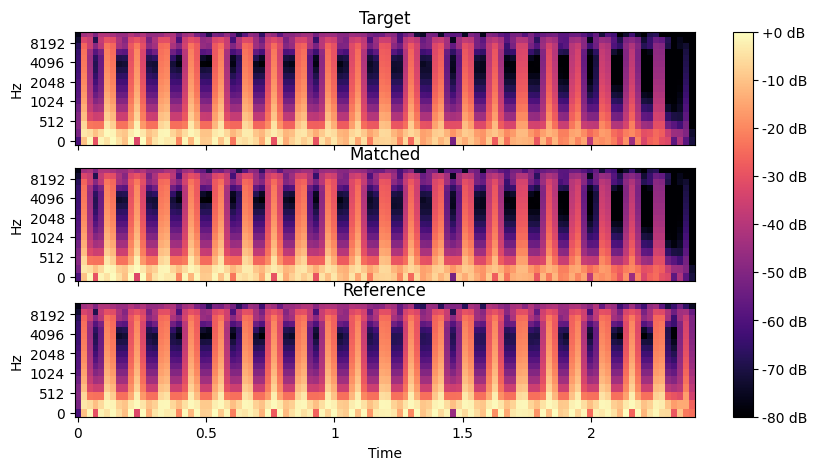

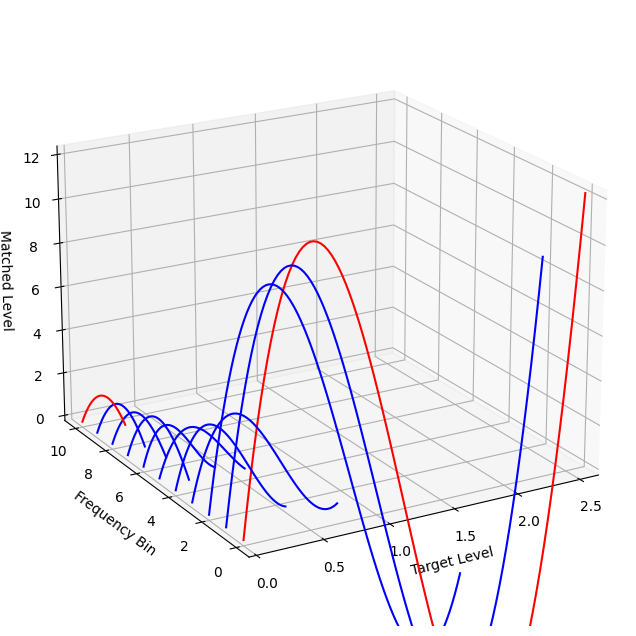

In [523]:
tAudio, rAudio = importAudio(target="tonequiet.wav",reference="toneloud.wav", output=False)

plotSpectrogram(tAudio, tAudio, rAudio)
coeffs = match(tAudio,rAudio,dynamicBins=64,order=3,searchSize=100,jump=10,plot=True,plotRange=(0,11))

#tSlice = tAudio["STFT"][100,:]
#rSlice = rAudio["STFT"][100,:]
#findMin(tSlice,rSlice,dynamicBins=64,order=3,searchSize=100,plot=True)

#tSlice = tAudio["STFT"][100,:]
#mSlice1 = warp(np.abs(tSlice), [-1])
#mSlice2 = warp(np.abs(tSlice), [1])
#mSlice1==mSlice2

#plotDynamics(tAudio["STFT"][100,:],rAudio["STFT"][100,:],[-18.73538423,64.65852413,-67.87420381,],64)
#plotDynamics(tAudio["STFT"][100,:],rAudio["STFT"][100,:],[18.73538423,-64.65852413,67.87420381,],64)


#np.abs(tAudio["STFT"][100,5]*-10)

#tAudio, rAudio = importAudio(target="audio_mono.wav",reference="audio2_mono.wav", output=True)

#[-67.87420381,64.65852413,-18.73538423,0]

#mAudio = EQMatching(tAudio,rAudio,smoothing=100, plot=True)



#exportAudio(tAudio, mAudio, rAudio)